# **XGBoost**

## **Intro**

### Welcome to the notebook on XGBoost! This is a legendary model and is used all over the world in many diffent problem domains. This algorithm can be used for classification (binary and multiclass), regression, and reccomendation toolkits. We almost did not include this in Code Grand Rounds as the underlying principles and mathematics are, to put it lightly, hard, but we will try and give you a high level overview and at least show you how to implement because this is really a great algorithm and is truly a classic.

### Boosting, at its core, is about correcting the mistakes of previous iterations. Imagine you're trying to teach a child a complex topic, say astrophysics. After your first explanation, the child might have grasped some concepts but not others. Instead of re-teaching everything from scratch, you focus on clarifying the parts they found difficult. This process repeats, honing in on the child's misconceptions until they have a good understanding of the whole topic. That, in essence, is how boosting works. With each iteration, the algorithm focuses more on the examples it got wrong previously, refining its predictions.

### XGBoost stands for Extreme Gradient Boosting. It takes the principle of boosting and implements it with optimizations that make the computation faster and more efficient. In XGBoost, trees are added one at a time, where each new tree corrects the errors of the preceding series of trees. The model allows for regularization which can further enhance its performance, and it can handle missing values, all while remaining scalable and portable.

### XGBoost, at its heart, relies on decision trees – but with a twist. In traditional decision trees, we construct the tree by making decisions at each node based on a certain criteria (e.g. Gini impurity) until we reach a leaf node, which gives us the final decision. The primary goal is to create branches that maximize the purity of the classification or minimize the error in regression. You can think of XGBoost as taking these decision trees and adding an iterative, sequential approach to their creation. Instead of constructing one tree and using it to make final predictions, XGBoost builds many trees in sequence, and each tree is designed to correct the mistakes (or, in technical terms, the "residual errors") of its predecessors.

### Imagine you're trying to teach a machine to identify a complex pattern. You start with a decision tree, and it does a reasonable job, but it misses some nuances. Instead of building a completely new tree, in XGBoost, you'd build another tree that focuses on the areas where the first tree was less accurate. This second tree doesn't replace the first one but rather complements it. And then you add another tree, and another, each one refining the decision-making process. An interesting note is that while each individual tree in XGBoost might be weak (meaning it's only slightly better than random guessing), when combined in sequence, their collective decision-making ability becomes highly accurate, strenth in numbers style. 

### This sequential addition of trees, each specializing in areas where previous trees were deficient, allows XGBoost to refine its model's accuracy over time, especially in complex datasets where relationships between variables aren't straightforward. It's like taking the concept of decision trees and enhancing it with the power of iterative learning. Another crucial aspect is the depth of these trees. In XGBoost, the trees are generally shallow. They are often referred to as "stumps" because they might have only one or a few levels. This is intentional; each tree is not meant to be a comprehensive model by itself but rather a piece of the puzzle. By combining many such "stumps" sequentially, XGBoost captures intricate patterns in the data.


### That was a lot of just pure text about XGBoost, but we hope the concept got across of what is happening. We will not get any deeper than this in explaining what is going in XGBoost, and from here on out things will look pretty similar. Lets dive in to predict those readmissions!


### Import Stuff

In [1]:
%pip install xgboost

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score



Note: you may need to restart the kernel to use updated packages.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Read in the dataset and preprocess the data the same way we did before

In [2]:
# Import the dataset
df = pd.read_csv('hospital_readmissions.csv')

# Do one hot encoding on medical specialty and the 3 diagnosis columns 
df_encoded = pd.get_dummies(df, columns=['medical_specialty'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_1'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_2'])
df_encoded = pd.get_dummies(df_encoded, columns=['diag_3'])

# Convert boolean columns (if any) to integers (1 and 0)
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)
        
# Make a dictionary of the age brackets where the key is the bracket and the value is the mean age
age_mapping = {
    '[40-50)': 45, 
    '[50-60)': 55, 
    '[60-70)': 65, 
    '[70-80)': 75, 
    '[80-90)': 85, 
    '[90-100)': 95
}

# Perform the actual mapping using the mapping method from pandas
df_encoded['age'] = df_encoded['age'].map(age_mapping)
# Make a dictionary of the categories where the key is the bracket and the value is the mean age
lab_mapping = {
    'no': 0, 
    'normal': 1, 
    'high': 2
}

# Perform the actual mapping using the mapping method from pandas
df_encoded['glucose_test'] = df_encoded['glucose_test'].map(lab_mapping)
df_encoded['A1Ctest'] = df_encoded['A1Ctest'].map(lab_mapping)

# Make a dictionary of the categories where the key is the bracket and the value is the mean age
binary_mapping = {
    'no': 0, 
    'yes': 1
    }

# Perform the actual mapping using the mapping method from pandas
df_encoded['change'] = df_encoded['change'].map(binary_mapping)
df_encoded['diabetes_med'] = df_encoded['diabetes_med'].map(binary_mapping)
df_encoded['readmitted'] = df_encoded['readmitted'].map(binary_mapping)


### Split train and testing data- nothing crazy here! You should be experts at this by now.

In [3]:
# Set the target variable and drop it from the dataset
y = df_encoded['readmitted']
X = df_encoded.drop(['readmitted'], axis=1)


# Splitting the data. We're keeping 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()


,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,glucose_test,A1Ctest,...,diag_2_Other,diag_2_Respiratory,diag_3_Circulatory,diag_3_Diabetes,diag_3_Digestive,diag_3_Injury,diag_3_Missing,diag_3_Musculoskeletal,diag_3_Other,diag_3_Respiratory
0,75,8,72,1,18,2,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,75,3,34,2,13,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,55,5,45,0,18,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,75,2,36,0,12,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,65,1,42,0,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## **Initial Classification**

### Do initial classification using XGBoost.  We have already performed some hyperparameter optimization for this data but left the code out as the process is essentially the same as you saw in the last notebook and it takes a long time to run for XGBoost. Just as a 'so you know', however, here is a list of the parameters we tuned and their role in the algorithm. 

- ### learning_rate: Determines the step size at each iteration while trying to minimize the loss function (much more in 'Intro to AI')
- ### max_depth: maximum depth of the decision tree
- ### min_child_weight: parameter to control against overfitting
- ### subsample:  fraction (or percentage) of rows used to build each tree. Helps in preventing overfitting
- ### colsample_bytree: fraction of the features (columns) samples to build each tree. Introduces randomness in by subsampling to prevent overfitting
- ### n_estimators: number of boosting rounds to run (number of trees you include in total)

### That being said, keep in mind the big picture of what XGBoost is doing.  XGBoost builds sequential trees where each tree tries to correct the errors made by the previous one: in isolation they are weak, but together they can become very strong! All of these hyperparameters play important roles in optimizing how the algorithm works, but it is more important for you to know are the broad strokes of what XGBoost is doing and why it is (theoretically) a good choice of machine learning model to use here.

### Lets now fit the model! `objective='binary:logistic'` is the loss function we used here as it is a binary classification task. For more on loss functions see Intro to AI! This code should look very similar to the Random Forests code except we now use the `XGBClassifier` class from `xgboost`

In [4]:
# classifier with optimized hyperparameters  (optimization not shown)
xgb = XGBClassifier(objective='binary:logistic',learning_rate= .01, max_depth = 3, min_child_weight=5, subsample= .4, colsample_bytree=.9, n_estimators=1250, random_state=42)

# Fit the model using training data
xgb.fit(X_train, y_train)

# make predictions on test set
y_pred = xgb.predict(X_test)

# make classification report
report = classification_report(y_test, y_pred)

# print
print('Classification Report: \n:', report)
print("ROC-AUC: \n", roc_auc_score(y_test, y_pred))


Classification Report: 
:               precision    recall  f1-score   support

           0       0.62      0.74      0.67      2658
           1       0.62      0.48      0.54      2342

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.61      5000

ROC-AUC: 
 0.6115619251037263


### Lets see how we did 

### **Classification Report**
### - Precision for Class 0: Out of all the instances predicted as not readmitted, 62% of them were accurate.

### -Precision for Class 1: For those predictions identified as readmitted, the model was correct 62% of the time. 

### - Recall for Class 0: Among the instances that are genuinely of not readmitted, our model managed to accurately predict 74% of them. Not bad!

### - Recall for Class 1: Of the actual instances that belong to readmitted, the model was successful in detecting 48% of them correctly. Could be better...

### - Accuracy: The model achieved a prediction accuracy of 62%. This implies that for every 100 predictions made by the model, it got 62 of them right.

### **AUCROC**
### The model's ROC-AUC score was 0.6115. So better than a coin toss, but definitely not a magic bullet. In fact, this is a worse AUROC than our single decision tree from the last notebook! Kind of disappointing, but hey, sometimes it do be like that. Lets take another stab at improving the model by evlaulating which features it determined as important.

## **Important Features**

### Now we are going to examine one built in feature of xgboost which is pretty cool and potentially helpful. We want to take a look at which features the XGBoost model thought were important when creating the classifier. It can sometimes be a helpful strategy to use only these features when training as the model chose them as being important. We can easily visualize them using the `plot_importance` method from xgboost. When doing machine learning we always care about our models being interpretable, which means we as human users have the ability to understand their behavior. 

<Figure size 1000x1500 with 0 Axes>

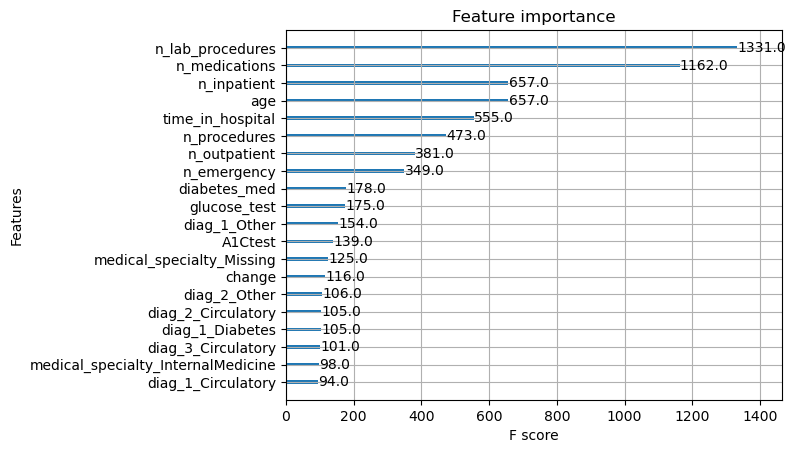

In [5]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 15))
plot_importance(xgb, max_num_features=20)  # Top 20 features
plt.show()

### By eye, it looks like there are clearly some features that are more important than others. F score represents the number of times that specfic feature was used to split the data across all the trees. The more times a feature was used to make a split, the more important that feature is.

### Here, we see that the number of lab procedures, medications, and number of inpatient visits were clearly important predictors for our model. Understanding how your model interprets your data is crucial for two reasons. The first, because it is highly interesting and can provide important insights into your model's behavior. The second is that sometimes you may realize your model is making predictions off things that are otherwise obvious.

### Imagine you were predicting COVID hospitalizations from a dataset and your model was performing with an AUROC of 98%. But then you check the important features and you see that pregnancy was one of the most important features, and that all of the people it predicted to be hospitalized or pregnant or recently postpartum. This basically means your model is able to identify a pregnant person and learn that they are at high risk of severe COVID symptoms. This is not very interesting, and you may want to do some more feature engineering to make your model more generalizable.

### For the sake of academic exploration, let's recreate our testing and training datasets using only the crucial features and assess if it enhances our model's performance! Lets use an arbitrary F Score cutoff of 300 and only use those features to train and test our model

In [6]:
# Set the target variable which does not change
y = df_encoded['readmitted']
# Set the 
X = df_encoded[['n_lab_procedures', 'n_medications', 'n_inpatient', 'age', 'time_in_hospital', 'n_procedures', 'n_outpatient', 'n_emergency']]


# Splitting the data. We're keeping 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# classifier with optimized features 

xgb = XGBClassifier(objective='binary:logistic',learning_rate= .01, max_depth = 3, min_child_weight=5, subsample= .4, colsample_bytree=.9, n_estimators=1250, random_state=42)

# Fit the model
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)
print("ROC-AUC: ", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2658
           1       0.61      0.47      0.53      2342

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.61      0.61      0.61      5000

ROC-AUC:  0.6057871793833803


### Bummer! This model that was trained on only the 'most' important features actually did worse based on AUC-ROC! And after all that excitement about XGBoost.

### So how could this happen? We talked earlier about XGBoost being this incredible, super cool algorithm. Well, it is an incredible super cool algorithm, but we have gently guided you into a very important lesson in machine learning- The No Free Lunch Theorem of Machine Learning. What this theorem states is there is not one perfect model that will work for all problems. Machine learning is an iterative process of working through your problem, trial, and error.

### While it's entirely possible and even likely that with more finetuning of the hyperparameters, different feature engineering, or altered data preprocessing we could improve both the XGBoost and the Random Forest even more, but at the same time, it's not a guarantee. And there are other models that might be even better than these for the readmissions dataset! The essence is that all of these factors play a role in machine learning, and when something doesn't produce the desired results, it's not a sign of failure but an indicator that you might need a different approach. Continuous learning and iterative trial and error are the name of the game in machine learning, and in addition to showing you XGBoost we hope this notebook also drives this point in further.

### In any event `congratulations` on making it this far! You are slowly and steady learning really hard stuff, so give yourself a pat on the back. On we go!